05_modeling

In [1]:
# 📦 Import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import sys

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    f1_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
# Extend module path for custom feature imports
sys.path.append(str(Path().resolve().parent))
from utils.mood_features import get_mood_index
from utils.feature_engineering import add_lag_features

In [3]:
# 🔄 Load and process data
df = pd.read_csv("../data/cleaned/cleaned_data.csv", parse_dates=["Date"])
df = get_mood_index(df)
df = add_lag_features(df)

In [4]:
# Encode Mood_Zone
df["Mood_Zone_Cat"] = df["Mood_Zone"].astype("category").cat.codes

# Final features and target
y = df["Target_NextWeekDrop"]
X = df.drop(columns=["Date", "Target_NextWeekDrop", "Mood_Zone"], errors="ignore")

In [5]:
# ✅ Paths
output_image_dir = Path("../images/modeling")
output_model_dir = Path("../models")
output_image_dir.mkdir(parents=True, exist_ok=True)
output_model_dir.mkdir(parents=True, exist_ok=True)

In [6]:
# 🧪 Train-test split
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

In [7]:
# 📌 Define models
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=RANDOM_STATE),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])
    ),
    "Dummy": DummyClassifier(strategy="most_frequent"),
    "LightGBM": LGBMClassifier(n_estimators=100, learning_rate=0.1, class_weight="balanced", random_state=RANDOM_STATE)
}

In [8]:
# 🔁 Stratified CV + metrics
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
results = []

for name, model in models.items():
    f1s, aucs = [], []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_tr, y_tr)
        probs = model.predict_proba(X_val)[:, 1]
        preds = (probs >= 0.5).astype(int)
        f1s.append(f1_score(y_val, preds))
        aucs.append(roc_auc_score(y_val, probs))
    results.append({
        "Model": name,
        "F1 Mean": np.mean(f1s),
        "ROC AUC Mean": np.mean(aucs)
    })

results_df = pd.DataFrame(results).sort_values(by="F1 Mean", ascending=False)
print(results_df)

[LightGBM] [Info] Number of positive: 293, number of negative: 421
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2687
[LightGBM] [Info] Number of data points in the train set: 714, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [9]:
# 🎯 Best model selection
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]
best_model.fit(X_train, y_train)
probs = best_model.predict_proba(X_test)[:, 1]

In [10]:
# 📌 Threshold tuning
thresholds = np.linspace(0.0, 1.0, 100)
f1_scores = [f1_score(y_test, probs >= t) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)
print(f"Best threshold: {best_threshold:.2f} with F1: {best_f1:.4f}")

Best threshold: 0.24 with F1: 0.5902


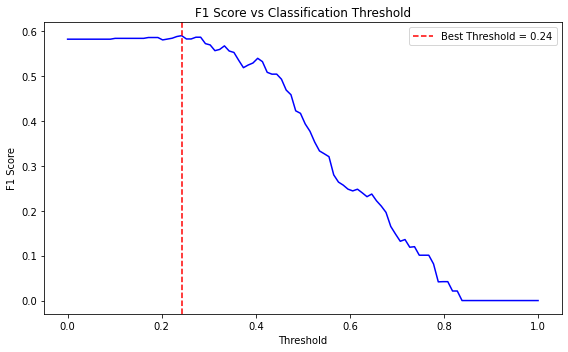

In [11]:
# 📉 Plot F1-score vs Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, color='blue')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f"Best Threshold = {best_threshold:.2f}")
plt.title("F1 Score vs Classification Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.legend()
plt.tight_layout()
plt.savefig(output_image_dir / "f1_vs_threshold.png",dpi=300, facecolor='white')
plt.show()

In [12]:
# 🧾 Final evaluation
final_preds = (probs >= best_threshold).astype(int)
print(classification_report(y_test, final_preds))

              precision    recall  f1-score   support

           0       0.82      0.07      0.13       132
           1       0.42      0.98      0.59        92

    accuracy                           0.44       224
   macro avg       0.62      0.52      0.36       224
weighted avg       0.66      0.44      0.32       224



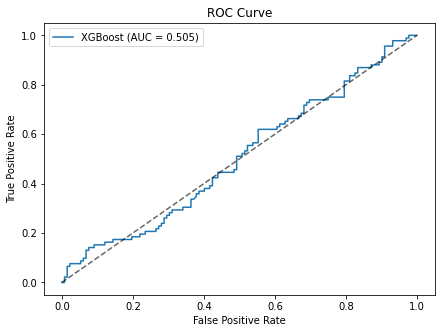

In [13]:
# 📈 ROC Curve
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"{best_model_name} (AUC = {roc_auc_score(y_test, probs):.3f})")
plt.plot([0, 1], [0, 1], "k--", alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig(output_image_dir / "roc_curve.png",dpi=300, facecolor='white')
plt.show()

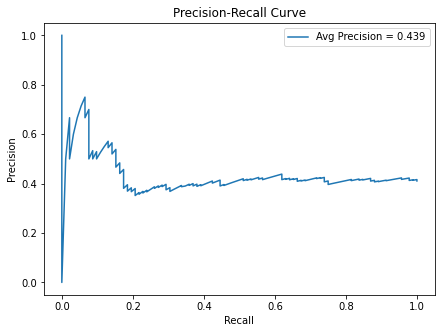

In [14]:
# 📈 PR Curve
precision, recall, _ = precision_recall_curve(y_test, probs)
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f"Avg Precision = {average_precision_score(y_test, probs):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.savefig(output_image_dir / "pr_curve.png",dpi=300, facecolor='white')
plt.show()

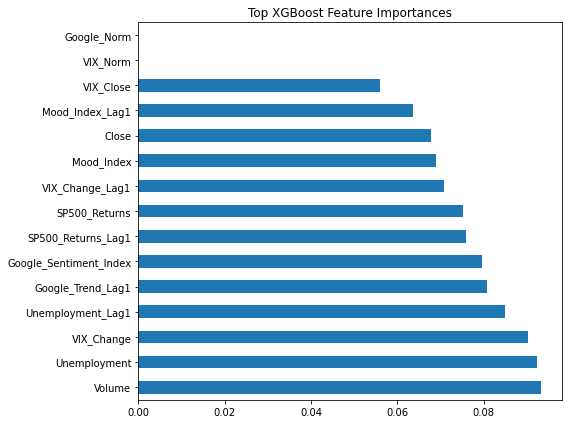

In [15]:
#TOP modelfeature_importance
if best_model_name == "XGBoost":
    feature_importance = pd.Series(best_model.feature_importances_, index=X.columns)
    feature_importance.nlargest(15).plot(kind="barh", figsize=(8,6), title="Top XGBoost Feature Importances")
    plt.tight_layout()
    plt.savefig(output_image_dir / "xgb_feature_importance.png",dpi=300, facecolor='white')
    plt.show()

In [16]:
#Displaying F1 Mean and ROC AUC Mean for each model
results_df

,Model,F1 Mean,ROC AUC Mean
3,XGBoost,0.424055,0.516859
5,LightGBM,0.377721,0.495735
2,KNN,0.364022,0.525541
0,LogisticRegression,0.321951,0.484318
1,RandomForest,0.295368,0.501738
4,Dummy,0.000000,0.500000


In [17]:
#Saving best model
joblib.dump(best_model, output_model_dir / f"{best_model_name}_model.pkl")

['..\\models\\XGBoost_model.pkl']

### 📌 Modeling Summary: Why Market Mood Forecasting Is Challenging

We tested multiple machine learning pipelines to predict next-week market mood drops, including:

- Class balancing with SMOTE
- Algorithms: Logistic Regression, Random Forest, KNN, LightGBM, and XGBoost
- Correlation filtering and lag feature engineering

Despite these efforts, none of the models significantly outperformed a baseline dummy classifier. The best-performing model (XGBoost) achieved a modest F1-score (~0.42), suggesting that the signal in the available features is weak for reliable binary classification.

This highlights the difficulty of short-term market forecasting, even when using mood-based signals and lagged indicators.
